# Setup

In [ ]:
!pip install -U git+https://github.com/IDEA-Research/GroundingDINO.git

In [ ]:
!pip install segmate

In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

In [5]:
%matplotlib ipympl

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import os
from PIL import Image
import json

import numpy as np
import matplotlib.pyplot as plt
import torch

import segmate
from segmate import utils, segmenter

# Utils

In [8]:
def show_image(
    img: np.ndarray,
    foreground_points = [],
    size: int=8,
    show_axis: bool=True,
    inter: int=500,
    points: tuple[list, list]=(None, None)
) -> None:
    """
    Shows the image and points if provided.

    Args:
        img (numpy.ndarray): The image to be shown.
        img_section (str): Show only a quarter of the image, options are 'top_left', 'top_right',
            'bottom_left', 'bottom_right'.
        size (int): Size of plot.
        show_axis (bool): Whether to show the axis or not.
        inter (int): Tick interval for axis.
        points (tuple): Tuple of point coordinates and labels to be plotted on the image,
            label '1' stands for foreground points, label '0' stands for background points.
    """
    height, width, _ = img.shape

    plt.close()

    f = plt.figure(figsize=(size, size))
    plt.xticks(np.arange(0, width, inter))
    plt.yticks(np.arange(0, height, inter))

    point_coords, point_labels = points
    if point_coords is not None and point_labels is not None:
        for pt, lbl in zip(point_coords, point_labels):
            style = "bo" if lbl == 1 else "ro"
            plt.plot(pt[0], pt[1], style)

    def onclick(event):
        ix, iy = event.xdata, event.ydata
        foreground_points.append((int(ix), int(iy)))
        plt.plot(ix, iy, "bo")

    cid = f.canvas.mpl_connect('button_press_event', onclick)

    plt.imshow(img)
    if not show_axis:
        plt.axis('off')
    plt.show()

In [9]:
def show_masks(image: np.ndarray, masks: np.ndarray, size: int=None, points: tuple=None) -> None:
    """
    Shows the masks.

    Args:
        image (numpy.ndarray): The image to be shown.
        masks (numpy.ndarray): The masks to be shown.
        int (int): The size of the plot.
    """
    image_pil = Image.fromarray(image)
    # Adjusted for single channel
    mask_overlay = np.zeros_like(image[..., 0], dtype=np.uint8)

    for i, mask in enumerate(masks):
        mask = mask[0, :, :]
        # Assign a unique value for each mask
        mask_overlay += ((mask > 0) * (i + 1)).astype(np.uint8)

    # Normalize mask_overlay to be in [0, 255]
    mask_overlay = (mask_overlay > 0) * 255  # Binary mask in [0, 255]

    # plt.close()

    if size:
        plt.figure(figsize=(size, size))

    if points:
        point_coords, point_labels = points
        for pt, lbl in zip(point_coords, point_labels):
            style = "bo" if lbl == 1 else "ro"
            plt.plot(pt[0], pt[1], style)

    plt.imshow(image_pil)
    plt.imshow(mask_overlay, cmap='viridis', alpha=0.4)  # Overlay the mask with some transparency
    plt.axis('off')
    plt.show()

# Model Initialization

In [11]:
sam = segmenter.SAM(model_type='vit_h', checkpoint='/content/drive/MyDrive/sam_vit_h_4b8939.pth')

# High Resolution Semantic Change Detection Dataset

In [12]:
dataset_dir = "/content/drive/MyDrive/semantic_change_detection_small_dataset"
images_2006 = "images_2006/D14"
images_2012 = "images_2012/D14"
labels_change = "labels_change/D14"
land_cover_labels_2006 = "land_cover_labels_2006/D14"
land_cover_labels_2012 = "land_cover_labels_2012/D14"

value_replacements = {
    0: 0,
    1: 50,
    2: 100,
    3: 150,
    4: 200,
    5: 250
}

labels = {
    0: 'No Information',
    1: 'Artificial Surfaces',
    2: 'Agricultural Areas',
    3: 'Forests',
    4: 'Wetlands',
    5: 'Water'
}

old_image_list = os.listdir(dataset_dir + '/' + images_2006)
all_prompts = []

In [13]:
new_image_list = os.listdir(dataset_dir + '/' + images_2012)

# Handcraft Prompts

In [275]:
img_path = images_2006 + '/' + old_image_list[11]
x_range = (0, 2000)
y_range = (0, 2000)

img = utils.load_image(dataset_dir+'/'+img_path)
part_img = img[x_range[0]:x_range[1], y_range[0]:y_range[1], :]

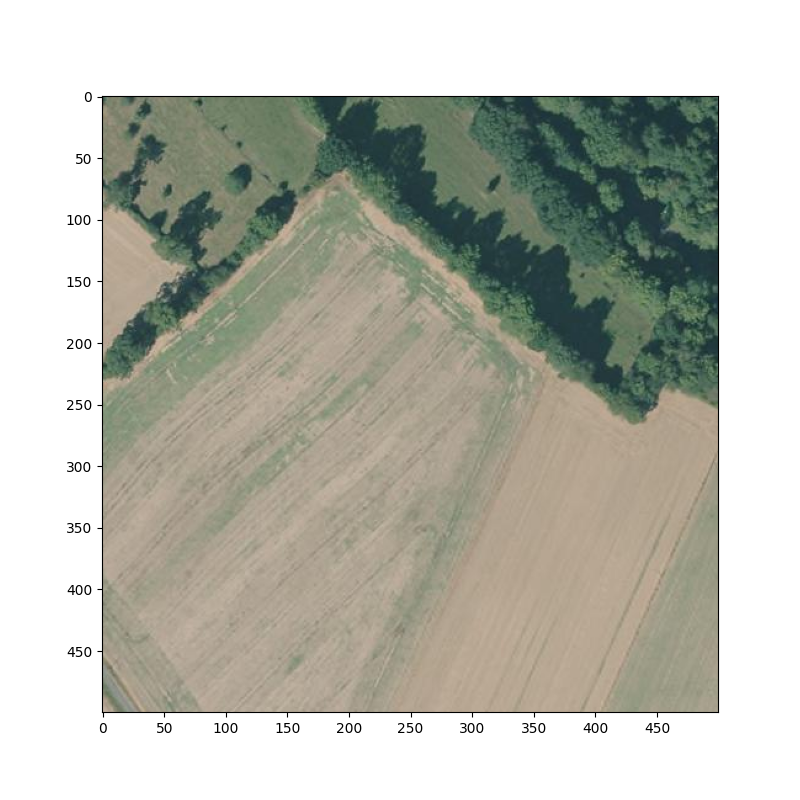

In [276]:
foreground_points = []
show_image(part_img, foreground_points, inter=50)

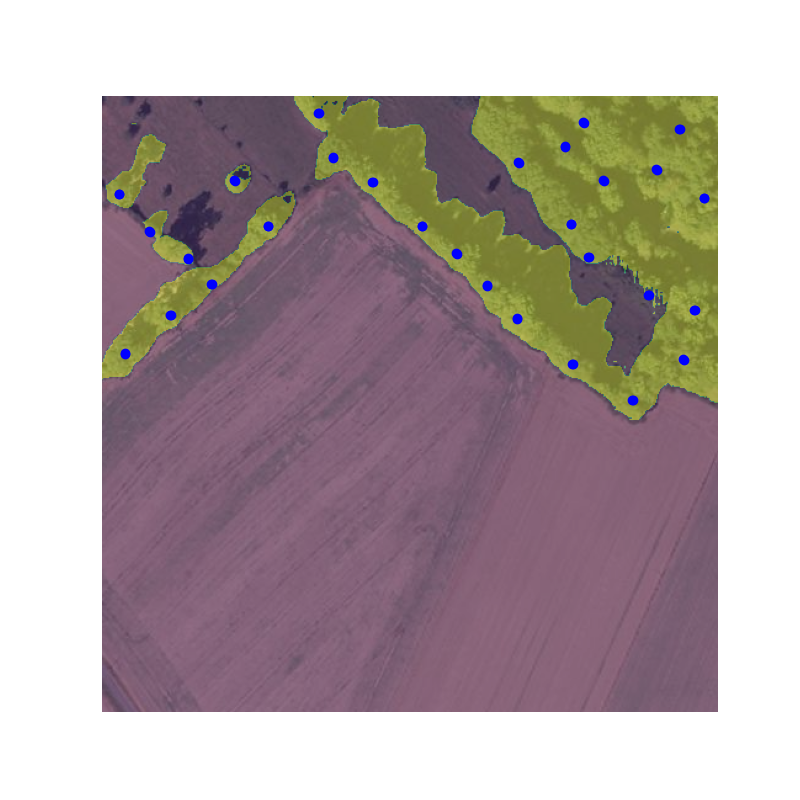

In [277]:
masks = sam.segment(part_img, points_prompt=(foreground_points, [1] * len(foreground_points)))
show_masks(part_img, masks, points=(foreground_points, [1]*len(foreground_points)))

In [278]:
prompt = {
    'img_path': img_path,
    'x_range': x_range,
    'y_range': y_range,
    'foreground_points': foreground_points
}
all_prompts.append(prompt)

In [280]:
with open("prompts.json", "w") as f:
    json.dump(all_prompts, f)